In [60]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

filename = "datasets/original_dataset.xlsx"
df = pd.read_excel(filename, engine='openpyxl')

df

,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_1,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10
0,984TAH,2015,0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,410VKN,2015,0,Val_40,5700.0,8.0,0.0,221.0,12.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,394ETK,2015,1,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,036KQK,2015,0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,996RNP,2015,0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017,0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,0.138413,0.496467,71.118364,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667
4595,538JZF,2017,1,Train_60,1600.0,0.0,NaN,338.0,NaN,1.0,...,0.108609,0.630414,50.562971,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000
4596,648WHI,2017,1,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,1.341142,0.985568,41.803426,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667
4597,899YZB,2017,1,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,1.419549,1.317842,48.831847,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667


In [64]:
# Impute the DataFrame
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])


df

,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_1,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10
0,984TAH,2015.0,0.0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,0.745562,0.936591,66.570012,6896.331199,71.340244,42912.46152,25271.78,44.961086,0.160746,0.333333
1,410VKN,2015.0,0.0,Val_40,5700.0,8.0,0.0,221.0,12.0,15.0,...,0.745562,0.936591,66.570012,6896.331199,71.340244,42912.46152,25271.78,44.961086,0.160746,0.333333
2,394ETK,2015.0,1.0,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,0.745562,0.936591,66.570012,6896.331199,71.340244,42912.46152,25271.78,44.961086,0.160746,0.333333
3,036KQK,2015.0,0.0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,0.745562,0.936591,66.570012,6896.331199,71.340244,42912.46152,25271.78,44.961086,0.160746,0.333333
4,996RNP,2015.0,0.0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,0.745562,0.936591,66.570012,6896.331199,71.340244,42912.46152,25271.78,44.961086,0.160746,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017.0,0.0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,0.138413,0.496467,71.118364,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667
4595,538JZF,2017.0,1.0,Train_60,1600.0,0.0,0.0,338.0,40.0,1.0,...,0.108609,0.630414,50.562971,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000
4596,648WHI,2017.0,1.0,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,1.341142,0.985568,41.803426,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667
4597,899YZB,2017.0,1.0,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,1.419549,1.317842,48.831847,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667


In [ ]:
# Separate data into training and validation sets
train_df = df[df['TrainVal'] == 'Train_60']
val_df = df[df['TrainVal'] == 'Val_40']

# Separate features and target variable
X_train = train_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
y_train = train_df['target']

X_val = val_df.drop(columns=['UniqueID','submission_year', 'target', 'TrainVal'])
y_val = val_df['target']

In [62]:
log_reg = LogisticRegression(penalty="l2", solver="liblinear")
param_grid = {'C': [0.001,0.01, 0.1, 1, 10, 100, 1000]}  #使用交叉验证查找正则化的逆值，逆值越小正则化强度越大The inverse of the regularization strength
clf = GridSearchCV(log_reg, param_grid, cv=5)  # 这里使用了5折交叉验证
clf.fit(X_train, y_train)
print("Best C value:", clf.best_params_['C'])
best_log_reg = clf.best_estimator_
model = SelectFromModel(best_log_reg, prefit=True)
X_train_new = model.transform(X_train)
X_val_new = model.transform(X_val)
model.get_support()
selected_features = np.array(X_train.columns)[model.get_support()]
print(selected_features)

Best C value: 0.01
['Long_2' 'Long_6' 'Long_7' 'Long_9' 'Short_8']


c:\Users\AdminnistratorDavid\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\AdminnistratorDavid\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


c:\Users\AdminnistratorDavid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


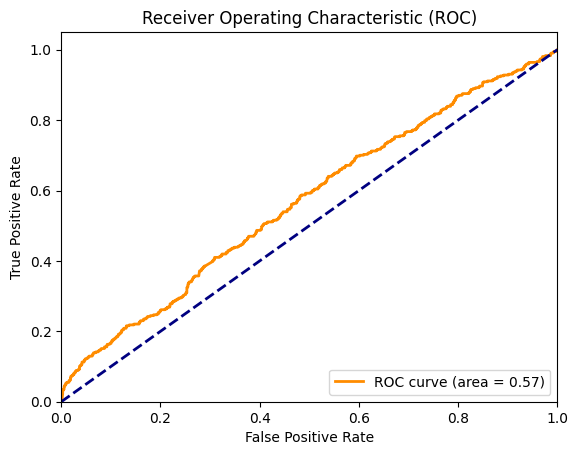

In [65]:
# AUC
from sklearn.metrics import roc_curve, auc
clf = xgb.XGBClassifier()
clf.fit(X_train_new, y_train)

# Predict on validation set
y_pred = clf.predict_proba(X_val_new)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Train the XGBoost model with default hyper parameter

# Compute accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Train the XGBoost model with hyper parameter tuning

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
}
clf = xgb.XGBClassifier()
grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train_new, y_train)

# Best hyperparameters
print(grid_search.best_params_)

best_clf = grid_search.best_estimator_

# Predict using the best model
y_pred = best_clf.predict(X_val_new)

# Compute accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy with best hyperparameters: {accuracy * 100:.2f}%")